In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
train_data = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv", index_col='id')
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [7]:
test_data = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv", index_col='id')
test_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
id,,,,,,,,,,,,,,,,
750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [11]:
cat_cols = train_data.select_dtypes(include=['object']).columns
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

print(f"The categorical value columns are: {categorical_cols.values}")
print(f"The numerical value columns are: {numerical_cols.values}")

The categorical value columns are: ['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'poutcome']
The numerical value columns are: ['age' 'balance' 'day' 'duration' 'campaign' 'pdays' 'previous' 'y']


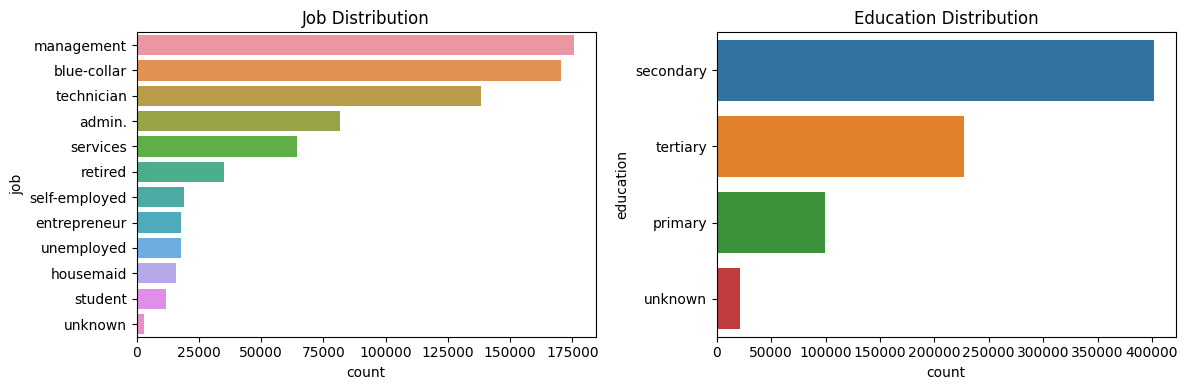

In [12]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.countplot(y='job', data=train_data, order=train_data['job'].value_counts().index, ax=axes[0])
axes[0].set_title('Job Distribution')
sns.countplot(y='education', data=train_data, order=train_data['education'].value_counts().index, ax=axes[1])
axes[1].set_title('Education Distribution')
plt.tight_layout()
plt.show()

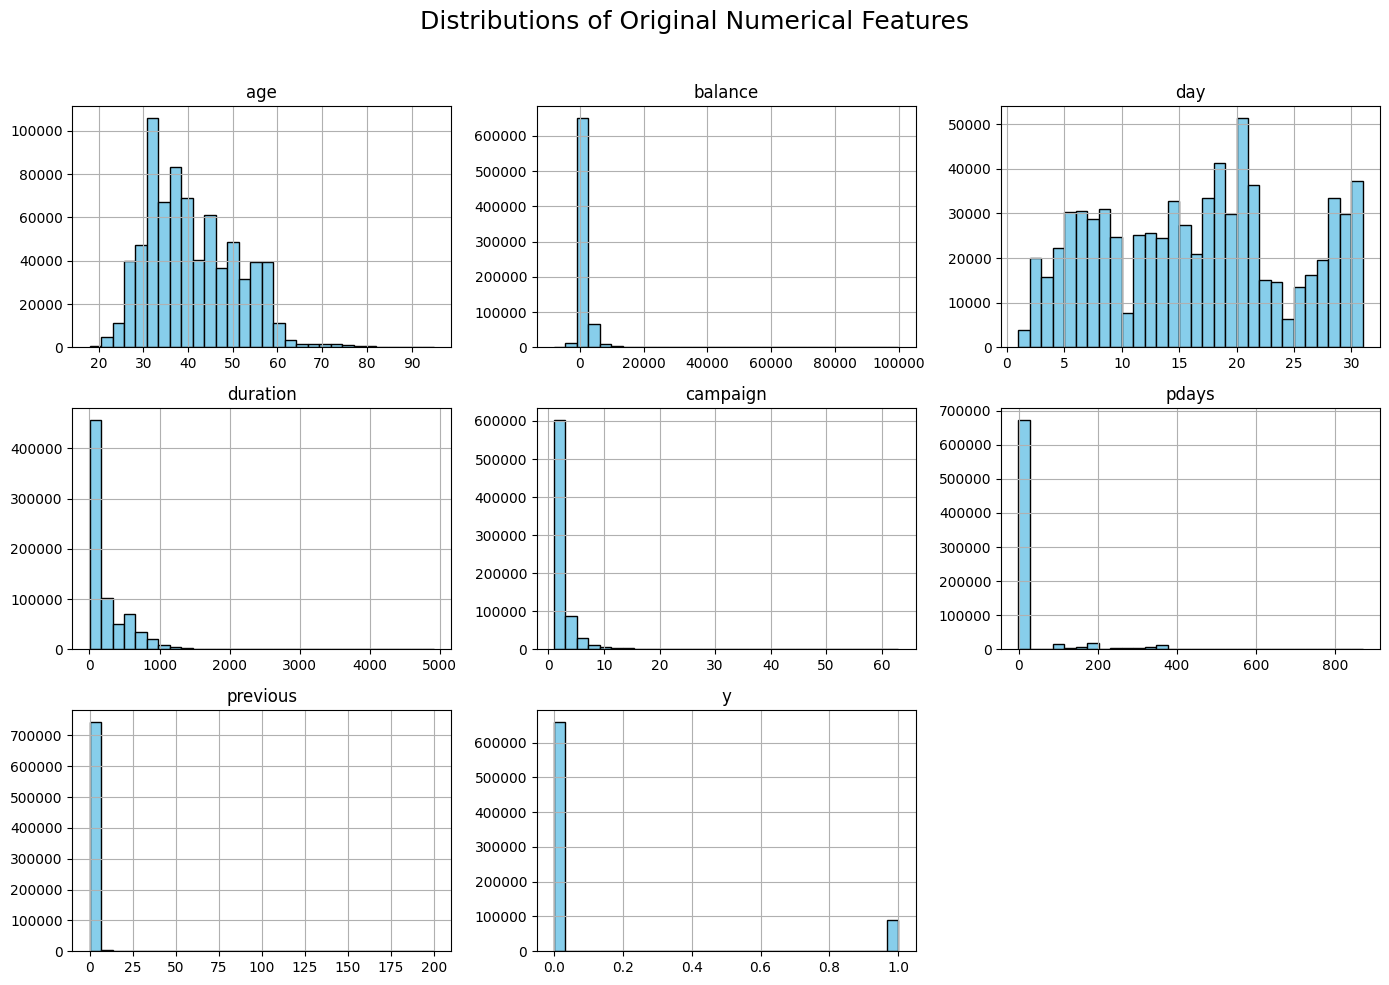

In [13]:
train_data[numerical_cols].hist(figsize=(14, 10), bins=30, color='skyblue', edgecolor='black')
plt.suptitle('Distributions of Original Numerical Features', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [15]:
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'] 
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

def preprocess(df):
    
    for col in numerical_cols:
        q1 = df[col].quantile(0.01)
        q99 = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=q1, upper=q99)
    
    
    df['duration_log'] = np.log1p(df['duration'])
    df['campaign_log'] = np.log1p(df['campaign'])
    df['pdays_log'] = np.log1p(df['pdays'] + 1)
    df['previous_log'] = np.log1p(df['previous'])
    df['balance_sqrt'] = np.sqrt(df['balance'] - df['balance'].min() + 1)
    df['age_squared'] = df['age'] ** 2
    
    
    df['balance_duration_ratio'] = df['balance'] / (df['duration'] + 1)
    df['campaign_previous_ratio'] = df['campaign'] / (df['previous'] + 1)
    
    
    for feature in cat_cols:
        df[feature] = df[feature].astype("category")
        
    
    if 'month' in df.columns:
        month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
        df['month_num'] = df['month'].map(month_map).astype('int8')
        
    return df


train_data = preprocess(train_data)
test_data = preprocess(test_data)

print("Feature engineering complete. New train shape:", train_data.shape)

Feature engineering complete. New train shape: (750000, 26)


In [6]:
X = train_data.drop('y', axis = 1)
X_eval = test_data
y = train_data['y']

In [7]:
xgb_params = {
    'eval_metric': 'auc',
    'learning_rate': 0.1,
    'max_depth': 13,
    'min_child_weight': 14,
    'gamma': 4.58625,
    'subsample': 0.88291,
    'colsample_bytree': 0.61064,
    'lambda': 9.97694,
    'alpha': 0.0018,
    'scale_pos_weight': 3.69634,
    'use_label_encoder': False,
    'enable_categorical': True,
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist'
}



In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_auc_scores = []
accuracy_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f"\n Fold {fold + 1}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = XGBClassifier(
        **xgb_params,
        early_stopping_rounds=50,
        n_estimators=1000
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)
    
    auc = roc_auc_score(y_val, y_pred_proba)
    acc = accuracy_score(y_val, y_pred)
    
    roc_auc_scores.append(auc)
    accuracy_scores.append(acc)
    
    print(f" ROC AUC: {auc:.4f} | Accuracy: {acc:.4f}")



 Fold 1
 ROC AUC: 0.9687 | Accuracy: 0.9212

 Fold 2
 ROC AUC: 0.9677 | Accuracy: 0.9198

 Fold 3
 ROC AUC: 0.9677 | Accuracy: 0.9189

 Fold 4
 ROC AUC: 0.9687 | Accuracy: 0.9207

 Fold 5
 ROC AUC: 0.9680 | Accuracy: 0.9198


In [14]:
predictions = model.predict(X_eval)
output = pd.DataFrame({'id': test_data.index, 'y': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


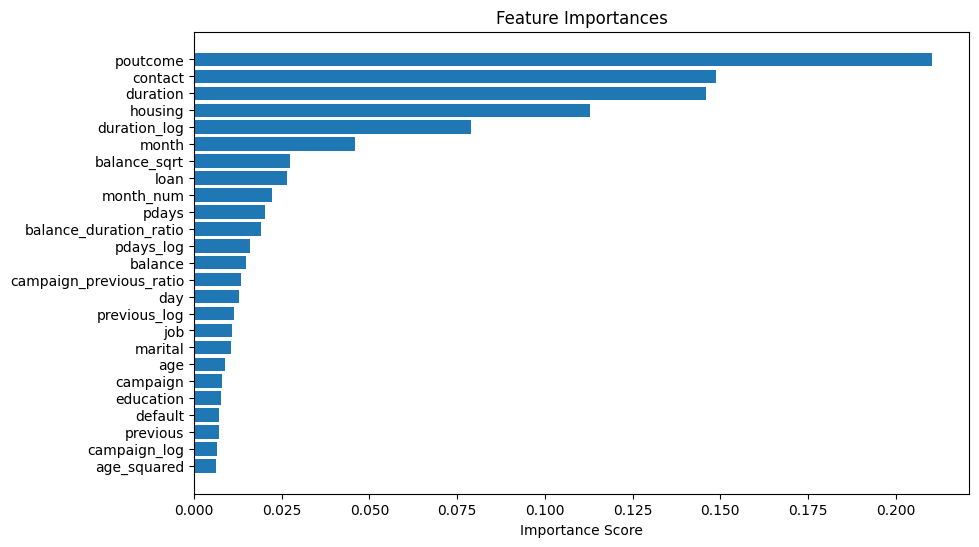

In [13]:
importances = model.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.show()